In [1]:
!unzip src.zip -d ./

Archive:  src.zip
   creating: ./src/
  inflating: ./src/PDE.py            
  inflating: ./src/PINN.py           
  inflating: ./src/NTK_helper.py     
   creating: ./src/__pycache__/
  inflating: ./src/__pycache__/NTK.cpython-310.pyc  
  inflating: ./src/__pycache__/NTK_helper.cpython-311.pyc  
  inflating: ./src/__pycache__/plotFunctions.cpython-311.pyc  
  inflating: ./src/__pycache__/PDE.cpython-311.pyc  
  inflating: ./src/__pycache__/PINN.cpython-311.pyc  
  inflating: ./src/__pycache__/NTK_helper.cpython-310.pyc  
  inflating: ./src/__pycache__/plotFunctions.cpython-310.pyc  
  inflating: ./src/__pycache__/PDE.cpython-310.pyc  
  inflating: ./src/__pycache__/PINN.cpython-310.pyc  
  inflating: ./src/plotFunctions.py  


In [2]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot  as plt

import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler

### Own modules
import sys
sys.path.insert(0, './src/')

from PDE import Poisson1D
from PINN import PINN
from plotFunctions import plot_param_ntk_diff, plot_NTK_change, plot_convergence_rate

### Set dtype and device to be used
dtype = torch.float32

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


### 1D Poisson

\begin{align}
u_{xx} &= f(x), \hspace{1.3cm} x \in \Omega \\
u(x) &= g(x), \hspace{1.3cm} x \in \partial \Omega
\end{align}

Where: 

\begin{align}
    f(x) &= -a^{2}\pi^{2}\sin(a\pi x), \hspace{0.2cm} x \in [0,1] \\
    g(x) &= 0, \hspace{2.3cm} x = 0,1
\end{align}

##### Define exact, source and boundary condition functions

In [ ]:
def f_u_exact(a,x):
    """ 
    Exact solution
    """
    u_exact = torch.sin(a*torch.pi*x)

    return u_exact

def f_x(a, x):
    """
    Source/Forcing function
    """
    fx = -(a**2)*(torch.pi**2)*torch.sin(a*torch.pi*x)
       
    return fx

def g_x(x, xb):
    """
    Boundary condition
    """
    
    ub = torch.zeros(x.size(), dtype=dtype)

    xb1_idx = torch.where(x == xb[0])[0]
    xb2_idx = torch.where(x == xb[1])[0]

    ub[xb1_idx] = 0
    ub[xb2_idx] = 0

    return ub

#### Setup data

In [ ]:
# Define PDE domain
X_0,X_N = 0.,1.
X_bc  = [X_0, X_N]

# Number of points
NX  = 100
dx = (X_N - X_0) / NX

# Create points for interior and boundary
Xr = torch.linspace(X_0, X_N, NX, dtype=dtype, device=device, requires_grad=True).view(-1,1)
Xb = torch.randint(0, 2, (NX,1),  dtype=dtype, device=device, requires_grad=True)
X  = torch.hstack((Xr, Xb))

### Setup PINN Network
Br      = 100
Bb      = 100
rand_sampler = RandomSampler(X, replacement=True)
XTrain       = DataLoader(X, batch_size=Br, shuffle=True)
training_batches = len(XTrain.dataset)

### Setup network training parameters

In [ ]:
# net parameters
input_size  = 1
output_size = 1

# Training parameters
learning_rate = 1e-5
epochs        = int(10e3)


## Result 1

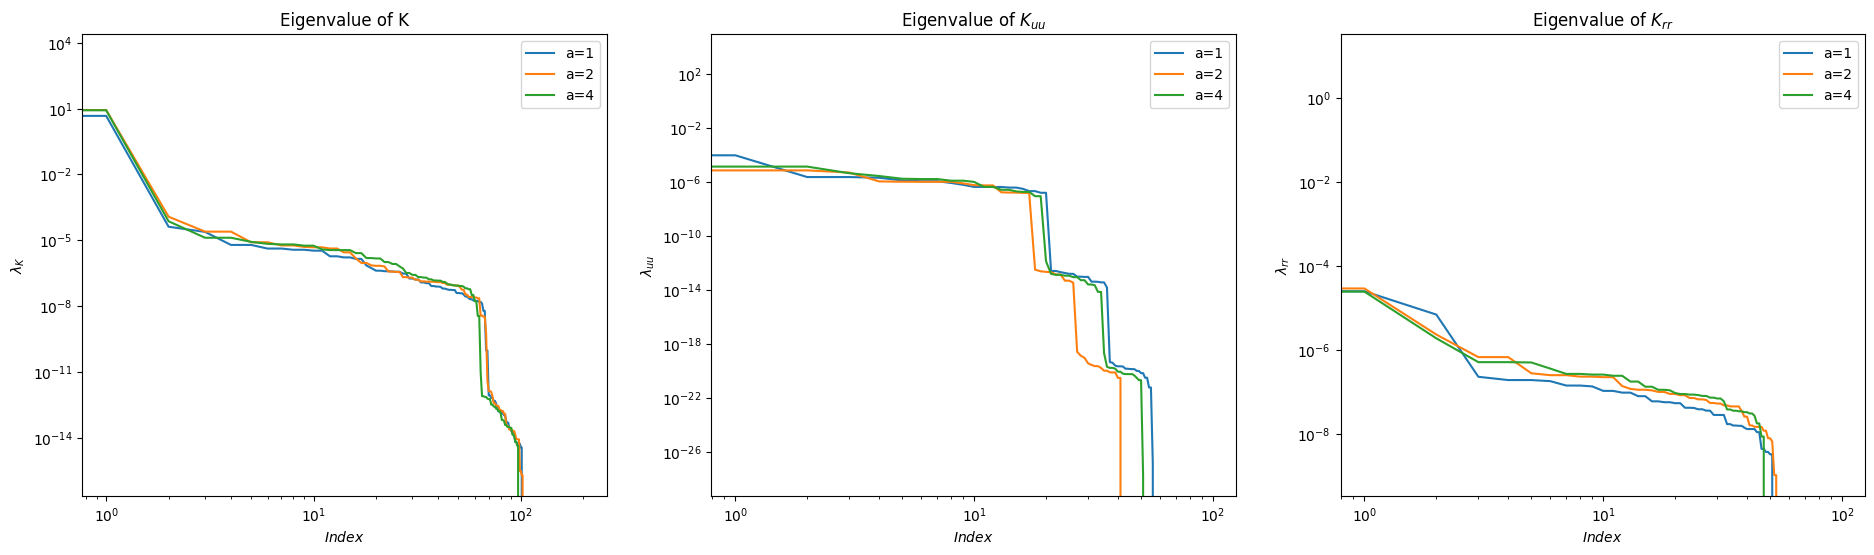

In [ ]:
### Setup PDE Equation
a   = [1, 2, 4]
PDE = [Poisson1D(a_i) for a_i in a]

# network neurons
neurons     = [100]

neural_nets =  [PINN(input_size, output_size, neurons, PDE_i, dtype, device).to(device) for PDE_i in PDE]; 

for net_i in neural_nets:
    net_i.eval()

### Observe initial estimation of NTK Matrix
X       = next(iter(XTrain))
X_prime = next(iter(XTrain))

xr       = X[:,0].to(device).view(-1,1);       xb       = X[:,1].to(device).view(-1,1)
xr_prime = X_prime[:,0].to(device).view(-1,1); xb_prime = X_prime[:,1].to(device).view(-1,1)

X = torch.stack([xr, xb], dim=0);      X_prime = torch.stack([xr_prime, xb_prime], dim=0)

### PLOT Eigenvalue of NTK matrices
fig, axs = plt.subplots(1,3, figsize=(23,6))
ylabels = [r'$\lambda_{K}$', r'$\lambda_{uu}$', r'$\lambda_{rr}$']

for i in range(len(a)):

    neural_nets[i].NTK(X, X_prime)

    eig_K_plot    = np.sort(np.real(neural_nets[i].lambda_K.detach().cpu().numpy()))[::-1]
    eig_K_uu_plot = np.sort(np.real(neural_nets[i].lambda_Kuu.detach().cpu().numpy()))[::-1]
    eig_K_rr_plot = np.sort(np.real(neural_nets[i].lambda_Krr.detach().cpu().numpy()))[::-1]

    axs[0].semilogx(eig_K_plot,      label=f'a={a[i]}');    axs[0].set_title('Eigenvalue of K')
    axs[1].semilogx(eig_K_uu_plot,   label=f'a={a[i]}');    axs[1].set_title('Eigenvalue of {}'.format(r"$K_{uu}$"))
    axs[2].semilogx(eig_K_rr_plot,   label=f'a={a[i]}');    axs[2].set_title('Eigenvalue of {}'.format(r"$K_{rr}$"))

for i,ax in enumerate(axs):
    ax.legend()
    # ax.ticklabel_format(axis='y', scilimits=(0,0))
    ax.set_yscale('log')
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel(r'$Index$')

plt.show()


## Result 2

### Setup PINN 

In [ ]:
#%%
neurons = [[10], [100], [500]]
a       = 4
PDE     = Poisson1D(a)

log_parameters  = True
log_NTK         = True

neural_nets  = [PINN(input_size, output_size, neurons_i, PDE, dtype, device, log_parameters=log_parameters, log_NTK=log_NTK) for neurons_i in neurons]

X       = next(iter(XTrain))
X_prime = next(iter(XTrain))

xr       = X[:,0].to(device).view(-1,1);       xb       = X[:,1].to(device).view(-1,1)
xr_prime = X_prime[:,0].to(device).view(-1,1); xb_prime = X_prime[:,1].to(device).view(-1,1)

x = torch.stack([xr, xb], dim=0);      x_prime = torch.stack([xr_prime, xb_prime], dim=0)


for net in neural_nets:
    net.to(device)
    net.NTK(x, x_prime)
    net.log_NTK(0)


In [ ]:

optimizer = optim.SGD
# optimizer = optim.Adam

optimizers = [optimizer(net_i.parameters(), learning_rate) for net_i in neural_nets]

### NTK computation settings
compute_NTK          = True
compute_NTK_interval = 10

### Adapation algorithm
use_adaptation_algorithm = False


In [ ]:

#### Train loop
train_losses = []
log_parameters = True

# Auto Mixed Precision settings
use_amp = True
scaler  = torch.cuda.amp.GradScaler(enabled=use_amp)

for epoch in range(epochs+1):
    epoch_loss   = 0.0

    for i, x in enumerate(XTrain):

        xr = x[:,0].view(-1,1).to(device); xb = x[:,1].view(-1,1).to(device)
        
        x  = torch.stack([xr, xb], dim=0)
        if i == len(XTrain) - 1 and epoch % compute_NTK_interval != 0:
            # get second data point set for NTK estimatino
            x_prime  = x

        for net, optimizer in zip(neural_nets, optimizers):

            net.train()

            if i == 0:
                net.log_parameters(epoch)

            # reset gradients  
            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):

                ### INTERIOR DOMAIN
                # Predict interior points
                u_hat_x   = net(xr)
            
                # determine gradients w.r.t interior points
                U_x       =  net.compute_pde_gradient(u_hat_x, xr)

                ### BOUNDARY DOMAIN
                u_hat_xb    = net(xb)

                # determine gradients w.r.t boundary points
                U_xb       =  net.compute_pde_gradient(u_hat_xb, xb)
                
                # Compute forcing/source function
                fx = f_x(a, xr).T.to(device)

                # compute boundary condition
                gx = g_x(xb, X_bc).T.to(device)

                # Stack
                U = torch.stack((U_x, U_xb), dim=0)

                ## Backward step
                net.backward(x, U, fx, gx, use_adaption=use_adaptation_algorithm)
                epoch_loss += net.loss.item()

            # Do optimisation step
            if use_amp:
                scaler.scale(net.loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                net.loss.backward()
                optimizers.step()
    ### END Batch loop

    # Compute NTK
    if epoch > 0:
        if (epoch % compute_NTK_interval == 0 or epoch == epochs - 1) and compute_NTK:

            for net in neural_nets:
                net.eval()
                net.NTK(x, x_prime)
                if log_NTK:
                    net.log_NTK(epoch)
    
    train_losses.append(epoch_loss / len(XTrain))
    
    if epoch % 100 == 0 or epoch == epochs - 1: 
        print(f"Epoch: {epoch:4d}     loss: {train_losses[-1]:5f}")

Epoch:    0     loss: 37030.893555
Epoch:  100     loss: 37030.101562
Epoch:  200     loss: 37029.119141
Epoch:  300     loss: 37027.945312
Epoch:  400     loss: 37026.406250
Epoch:  500     loss: 37024.377930
Epoch:  600     loss: 37021.644531
Epoch:  700     loss: 37017.953125
Epoch:  800     loss: 37013.014648
Epoch:  900     loss: 37006.541992
Epoch:  999     loss: 36998.446289
Epoch: 1000     loss: 36998.365234


#### Result plot

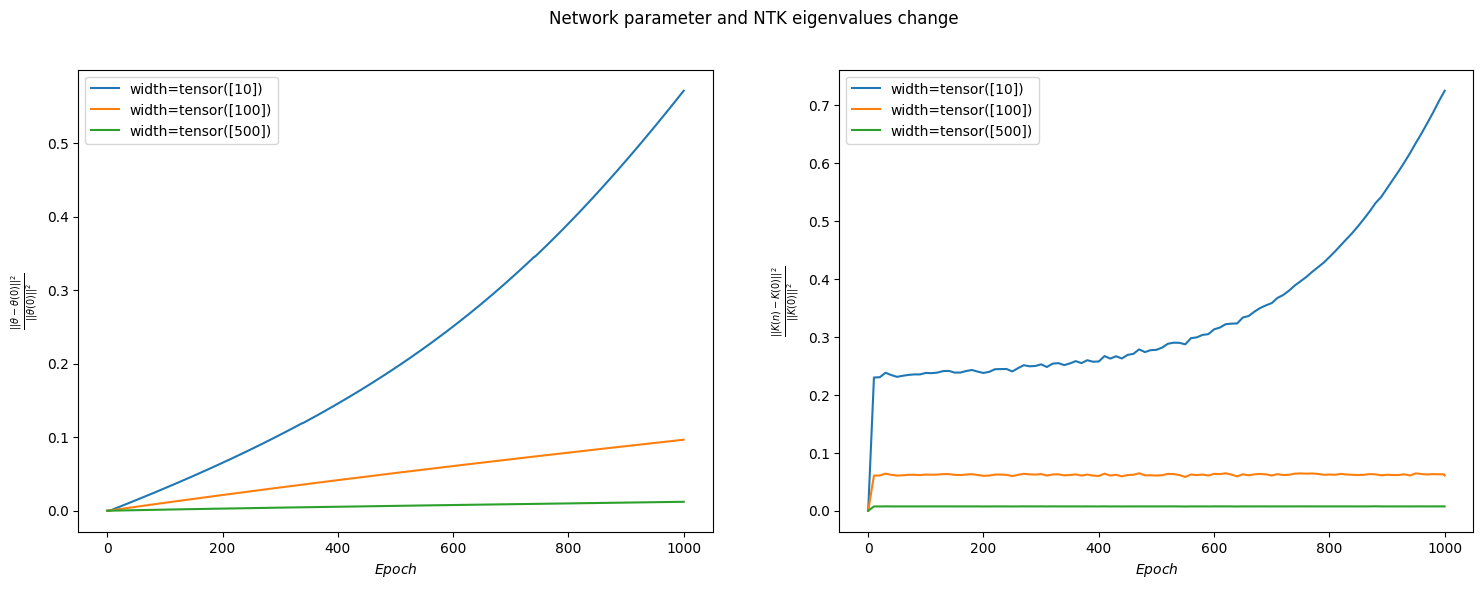

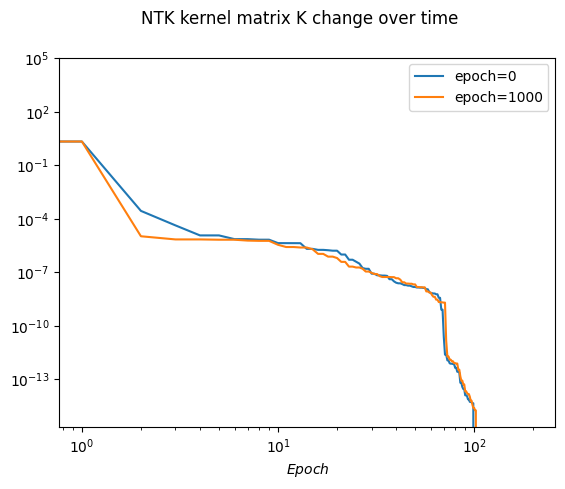

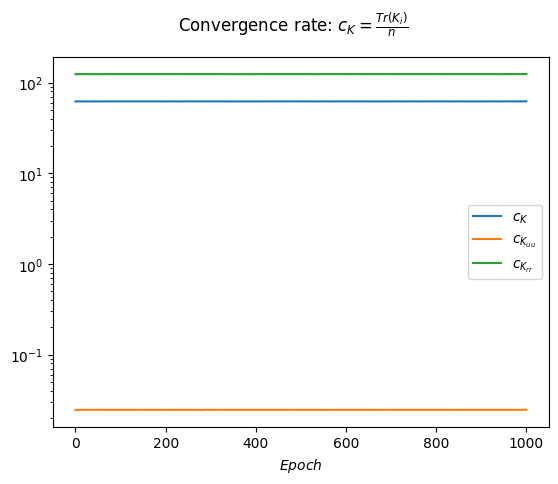

In [ ]:

# Plot 1 - Parameter and ntk difference
fig1, axs1 = plt.subplots(1,2, figsize=(18,6))
 
for net in neural_nets:
    fig1, axs1 = plot_param_ntk_diff(net, fig1, axs1)

# FOR LARGEST WIDTH NETWORK  !!!@!
net      = neural_nets[-1]

# plot NTK matrix K change
fig2, axs2 = plt.subplots(1,1)
plot_NTK_change(net, fig2, axs2)

# Plot convergence rate for all matrices
fig3, axs3 = plt.subplots(1,1)
plot_convergence_rate(net, fig3, axs3)

plt.show()
